In this note, we will train a classifier on the dataset Iris, using mini-Batch Gradient Descent Descent. The detail of Iris can be found at https://archive.ics.uci.edu/ml/datasets/iris.

We will perform grid search to find good hyperparameters (the learning rate eta, the coefficient of the regularization term C, and batch size)

We use <i>softmax</i> as the loss function.

Here are steps:
#1. load the dataset
#2. create train, dev, test sets
#3. train a model using grid search
#4. evaluate the final model

We will compare full and mini batch GD

In [10]:
#helping functions

from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import random

#plot a line

def plotxy(x, y, label):
    plt.plot(x, y, label = label)


#load data
def get_Iris():
    return load_iris(as_frame=True)

#add bias term (x_0 = 1)
def add_bias_term(x):
    return np.c_[np.ones(len(x)), x]

#convert a category column into one-hot matrix
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]


def train_dev_test_split(X, y, dev_ratio = 0.2, test_ratio = 0.2):
    total_size = len(X)

    test_size = int(total_size * test_ratio)
    dev_size = int(total_size * dev_ratio)
    train_size = total_size - test_size - dev_size

    np.random.seed(42)
    rnd_indices = np.random.permutation(total_size)

    X_train = X[rnd_indices[:train_size]]
    y_train = y[rnd_indices[:train_size]]
    X_dev = X[rnd_indices[train_size:-test_size]]
    y_dev = y[rnd_indices[train_size:-test_size]]
    X_test = X[rnd_indices[-test_size:]]
    y_test = y[rnd_indices[-test_size:]]

    return X_train, X_dev, X_test, y_train, y_dev, y_test

#compute softmax(s) of a vector
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums




def train_in_mini_batch(X_train, X_dev, Y_train_one_hot, Y_dev_one_hot, batch_size, eta = 0.5, n_epochs = 51, C = 0, L = 5 ):
#batch_size: number of samples used to compute the gradients
#eta: learning rate
#n_epochs: number of iterations to train a model
#1/C: the coefficient "alpha" in regularization term L2, C = very big number means no regularization
#L: we will compute the train and dev loss every L iterations
#It will take much time if we compute these losses each iteration. 
#Moreover, there may not be a significant change between 2 consecutive iterations
#Setting L = 1 means computing these losses each iteration

#return the trained model, Theta and the two losses

#set up
    m = len(X_train)
    n_inputs = X_train.shape[1]  #(all features, including the bias term)
    n_outputs = len(Y_train_one_hot[0])  # for example = 3 (there are 3 iris classes)
    
    epsilon = 1e-5 #we will add a tiny value 𝜖 to log(𝑝̂ (𝑖)𝑘) to avoid getting nan values 
    
    np.random.seed(42)
    Theta = np.random.randn(n_inputs, n_outputs)
    train_loss = []
    dev_loss = []

    
    #print(X_train.shape)
    #print(Y_train_one_hot.shape)
#Start to train
    
    for epoch in range(n_epochs):
        
        #compute y_hat = Y_proba
        
        rnd_indices = random.sample(range(m), batch_size)
        
        X_batch = X_train[rnd_indices]
        Y_train_one_hot_batch = Y_train_one_hot[rnd_indices] #for update Theta
        
        logits_batch = X_batch @ Theta  #@ matrix multiplication operator; 
        Y_train_proba_batch = softmax(logits_batch) #for update Theta

        Y_train_proba = softmax(X_train @ Theta) #for computing the train and dev losses


        #we compute train, dev losses every 100 iterations.  

        if epoch % L == 0:
        
            #train loss
            xentropy_losses = -(Y_train_one_hot * np.log(Y_train_proba + epsilon))
            l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
            total_train_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
        
            #dev loss
            Y_dev_proba = softmax(X_dev @ Theta)
            xentropy_losses = -(Y_dev_one_hot * np.log(Y_dev_proba + epsilon))
            l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
            total_dev_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
            
            train_loss.append(total_train_loss)
            dev_loss.append(total_dev_loss)
            
            #we can commemt the following print if we do not want to see train, dev loss in training process
            #but we need to print them out when we train the model at the time 
            #since if something wrong (e.g. the loss goes up) we can manually stop the algoritm right away to save time
            
            #print("iteration, train, dev losses: ", epoch, ", ", total_train_loss, ", ", total_dev_loss)
        
        #update Theta
        error = Y_train_proba_batch - Y_train_one_hot_batch
        gradients = 1 / m * X_batch.T @ error
        gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
        Theta = Theta - eta * gradients
        
    return Theta, train_loss, dev_loss



def predict(Theta, X):
    logits = X @ Theta
    Y_proba = softmax(logits)
    return Y_proba.argmax(axis=1)

def accuracy(y, y_hat):    
    accuracy_score = (y == y_hat).mean()
    return accuracy_score

    

In [11]:

def main_mini_batch():

    #get data
    iris = get_Iris()
    X, y = iris.data.values, iris["target"].values
    
    X_with_bias = add_bias_term(X)
    
    #create train, dev, test set
    dev_ratio, test_ratio = .2, .2
    X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test_split(X_with_bias, y, dev_ratio, test_ratio)
    
    
    #since all ys have categorical values in {0, 1, 2}  
    #we need to convert all ys in one-hot vectors 
    #that is because we will use softmax loss function to compute probabilies (in range [0, 1])
    #note: we use Y instead of y since Y_train_one_hot is a matrix, not a vector (we use y for a vector) 

    Y_train_one_hot = to_one_hot(y_train)
    Y_dev_one_hot = to_one_hot(y_dev)
    Y_test_one_hot = to_one_hot(y_test)
    
    #scaling
    #Note: we do NOT scale the first column since it is the bias term (=1)
    
    mean = X_train[:, 1:].mean(axis=0)
    std = X_train[:, 1:].std(axis=0)
    X_train[:, 1:] = (X_train[:, 1:] - mean) / std
    X_dev[:, 1:] = (X_dev[:, 1:] - mean) / std
    X_test[:, 1:] = (X_test[:, 1:] - mean) / std
    
    #training

    #-----train models with combinations of eta and C
    n_epochs = 1000
    L = 50

    list_eta = [1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
    list_eta = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
    list_eta = [1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008, 1.009]
    list_eta = [1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09]
    list_eta = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    


    list_C = [80250, 80200, 80150, 80000, 80100, 80125, 80050, 1000, 10]
    list_C = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
    list_C = [210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]


    list_batch_size = [20]
    
    list_models = []
    list_train_loss = []
    list_dev_loss = []
    
    for eta in list_eta:
        for C in list_C:
            for batch_size in list_batch_size:
                Theta, train_loss, dev_loss = train_in_mini_batch(X_train, X_dev, Y_train_one_hot, Y_dev_one_hot, batch_size, eta, n_epochs, C, L )
                list_models.append(Theta)
                list_train_loss.append(train_loss)
                list_dev_loss.append(train_loss)
                
    #-----find the best model
    #-----here the best model is the one with the minimum train loss 

    i = 0
    best_ind, best_C, best_eta, best_batch_size, min_train_loss = 0, list_C[0], list_eta[0], list_batch_size[0], min(list_train_loss[0])
    
    for eta in list_eta:
        for C in list_C:
            for batch_size in list_batch_size:
                m = min(list_train_loss[i])
                if min_train_loss > m:
                    min_train_loss = m
                    best_eta, best_C, best_batch_size, best_ind = eta, C, batch_size, i
                i += 1
            
    best_train_loss, best_dev_loss, best_Theta = list_train_loss[best_ind], list_dev_loss[best_ind], list_models[best_ind]
    
    
    
    #plot train and dev losses against the training times

    plt.plot(np.arange((len(best_train_loss)))* L, best_train_loss, label = "best train loss")
    plt.plot(np.arange((len(best_dev_loss))) * L, best_dev_loss, label = "best dev loss")

    plt.xlabel = "Time Steps"
    plt.ylabel = "Error"

    plt.legend()
    plt.show()

    #compute train, test accuracy
    #since the dataset is uniform in terms of label distribution, 
    #we can use accuracy as a metric to evaluate the performman of the final model

    #train_acc
    y_train_predict = predict(best_Theta, X_train)
    train_acc = accuracy(y_train, y_train_predict)

    y_test_predict = predict(best_Theta, X_test)
    test_acc = accuracy(y_test, y_test_predict)

    print("best train, best test accuracies: ", train_acc, test_acc)
    print("best eta, best C, best_batch_size: ", best_eta, best_C, best_batch_size)
    #return Theta, train_loss, dev_loss, L
  

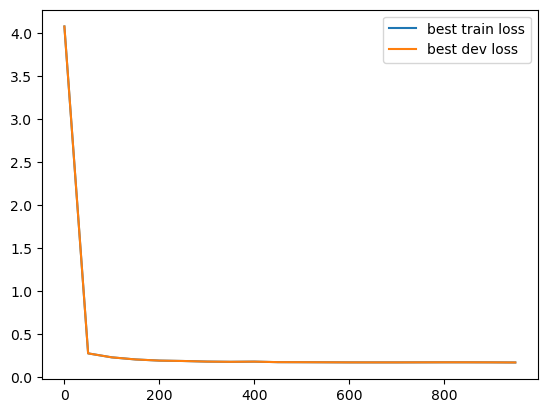

best train, best test accuracies:  0.9777777777777777 0.9666666666666667
best eta, best C, best_batch_size:  1.9 400 20


In [12]:
main_mini_batch()

best train, best test accuracies:  0.9777777777777777 0.9666666666666667
best eta, best C, best_batch_size:  1.9 400 20

best train, best test accuracies:  0.9666666666666667 0.9666666666666667
best eta, best C, best_batch_size:  1.06 200 30

best train, best test accuracies:  0.9666666666666667 0.9666666666666667
best eta, best C, best_batch_size:  1.7 200 20

best train, best test accuracies:  0.9666666666666667 0.9666666666666667
best eta, best C, best_batch_size:  1.06 200 20

best train, best test accuracies:  0.9666666666666667 0.9666666666666667
best eta, best C, best_batch_size:  1.004 200 20

Here we can take the best model with 96.67% accuracy for train and dev sets.

I wanted to use batch_size value in the set of {20, 30} since the full batch has 150 * 60% = 90 samples. That way, we use 1/4 to 1/3 the whole dataset for updating the model each iteration, and the train and dev losses start to converge at the iteration $200^{th}$. This is reasonable. Using big values for batch_size will loose the benefit of mini-batch GD.

I decide to stop exploring combinations of eta and C here since the learning rate is good now (the algorithm learn smoothly and converges quickly) and the regularization works fine (train and dev accuracies are the same in every iteration).

Comparison: full batch vs. mini-batch

As we can see the performance of the model trained with mini-batch GD is far-away from that trained with full batch GD, above 3% lower accuracy. That is expected since mini-batch GD can make the algorithm bounce up and down, then close to but not settle at the optimum solution. However, mini-batch GD saves the time complexity of training process up to 3-4 times training time of full batch GD. It is not much worth since this dataset is not big to take time for training.   

In conclusion, I will use full batch GD to train a classifier for the dataset Iris.  